### Update Scikit learn package

In [ ]:
!pip install -U scikit-learn

#### Important - before your proceed please restart the kernel from the Kernel menu at the top of the window 

### Load data

We downloaded the wine magazine dataset from [Kaggle](https://www.kaggle.com/pabloa/wine-magazine) and provided the zip file as part of the GitHub repository  

In [ ]:
!unzip winemagazine-dataset.zip

In [88]:
import pandas as pd
# Let's first load the data into a Pandas dataframe so it is easy for us to work with it
wine_raw_df = pd.read_csv('./winemag-data_first150k.csv', sep=';',header=0)
wine_raw_df.shape

(144037, 10)

In [89]:
# display the first few rows
wine_raw_df.head()

,country,designation,points,price,province,region_1,region_2,variety,winery,last_year_points
0,US,Martha's Vineyard,96.0,235.0,California,Napa Valley,Napa,Cabernet Sauvignon,Heitz,94
1,Spain,Carodorum Selección Especial Reserva,96.0,110.0,Northern Spain,Toro,NaN,Tinta de Toro,Bodega Carmen Rodríguez,92
2,US,Special Selected Late Harvest,96.0,90.0,California,Knights Valley,Sonoma,Sauvignon Blanc,Macauley,100
3,US,Reserve,96.0,65.0,Oregon,Willamette Valley,Willamette Valley,Pinot Noir,Ponzi,94
4,France,La Brûlade,95.0,66.0,Provence,Bandol,NaN,Provence red blend,Domaine de la Bégude,94


### Explore the data

In [90]:
# First let us determine if there are any missing values
wine_raw_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144037 entries, 0 to 144036
Data columns (total 10 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   country           144035 non-null  object 
 1   designation       100211 non-null  object 
 2   points            144032 non-null  float64
 3   price             130641 non-null  float64
 4   province          144030 non-null  object 
 5   region_1          120192 non-null  object 
 6   region_2          58378 non-null   object 
 7   variety           144032 non-null  object 
 8   winery            144032 non-null  object 
 9   last_year_points  144037 non-null  int64  
dtypes: float64(2), int64(1), object(7)
memory usage: 11.0+ MB


Except the column **last_year_points** almost all columns have null values. Total number of rows is 144037 as shown in RangeIndex. if the count of Non-Null for each column is less than 144037, the difference indicates the number of nulls we have. We need to use the technique of imputation to determine how to fill the missing values for these columns. Our feature engineering strategy will be:

1. Impute the missing values in the column ~price, and drop the rows where ~points ~winery ~country and ~variety are null because they are very few and dropping them won't impact the quality of training
1. Determine the encoding strategy for **designation, variety and winery** columns because these have categorical tendencies
1. Check if encoding leads to too large a value range for features and if so perform scaling and normalization as needed
1. Explore the columns ~region_1 ~region_2 in detail and determine what needs to be done with them
1. Visualize the correlation for the dataset across columns and finalize features 

### Missing values

In [91]:
# what is the price range
wine_raw_df['price'].value_counts()

20.0     7489
15.0     6762
18.0     5700
25.0     5698
30.0     5168
         ... 
266.0       1
172.0       1
151.0       1
580.0       1
243.0       1
Name: price, Length: 351, dtype: int64

In [71]:
# Lets get the count of null values before imputation
wine_raw_df['price'].isnull().sum()

13396

In [92]:
# we have prices ranging from $20 to $243 per bottle of wine - nice
# We can use a simple pandas imputation technique to replace the missing values in price to a mean value
wine_raw_df['price'] = wine_raw_df['price'].fillna(wine_raw_df['price'].mean())
# count the null values to see if anything remains - 0 is good
wine_raw_df['price'].isnull().sum()

0

In [73]:
wine_raw_df.query('designation != designation')

,country,designation,points,price,province,region_1,region_2,variety,winery,last_year_points
36,France,NaN,90.0,60.0,Rhône Valley,Châteauneuf-du-Pape,NaN,Rhône-style White Blend,Clos de L'Oratoire des Papes,98
37,Italy,NaN,90.0,29.0,Tuscany,Vino Nobile di Montepulciano,NaN,Sangiovese,Avignonesi,88
38,Italy,NaN,90.0,23.0,Tuscany,Chianti Classico,NaN,Sangiovese,Casina di Cornia,82
48,Italy,NaN,90.0,50.0,Tuscany,Brunello di Montalcino,NaN,Sangiovese,Brunelli Martoccia,98
49,US,NaN,90.0,40.0,Washington,Red Mountain,Columbia Valley,Cabernet Sauvignon,Canvasback,84
...,...,...,...,...,...,...,...,...,...,...
144007,US,NaN,82.0,10.0,California,California,California Other,Pinot Noir,Camelot,95
144009,Chile,NaN,82.0,7.0,Maipo Valley,NaN,NaN,Pinot Noir,Undurraga,98
144019,France,NaN,89.0,38.0,Burgundy,Chambolle-Musigny,NaN,Pinot Noir,Michel Gros,85
144032,Italy,NaN,91.0,20.0,Southern Italy,Fiano di Avellino,NaN,White Blend,Feudi di San Gregorio,84


In [74]:
wine_raw_df['designation'].mode()

0    Reserve
dtype: object

In [93]:
# designation also has a lot of null values let us impute using mode
wine_raw_df['designation'] = wine_raw_df['designation'].fillna('Reserve')
# count the null values to see if anything remains - 0 is good
wine_raw_df['designation'].isnull().sum()

0

### Feature selection

In [94]:
# Lets look at the null value columns once again
wine_raw_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144037 entries, 0 to 144036
Data columns (total 10 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   country           144035 non-null  object 
 1   designation       144037 non-null  object 
 2   points            144032 non-null  float64
 3   price             144037 non-null  float64
 4   province          144030 non-null  object 
 5   region_1          120192 non-null  object 
 6   region_2          58378 non-null   object 
 7   variety           144032 non-null  object 
 8   winery            144032 non-null  object 
 9   last_year_points  144037 non-null  int64  
dtypes: float64(2), int64(1), object(7)
memory usage: 11.0+ MB


In [95]:
# region_2 has a lot of nulls lets have a look 
wine_raw_df['region_2'].value_counts()

Central Coast              12870
Sonoma                     11084
Napa                        8623
Columbia Valley             7882
California Other            3477
Willamette Valley           2853
Mendocino/Lake Counties     2353
Sierra Foothills            1630
Napa-Sonoma                 1629
Finger Lakes                1484
Central Valley              1107
Long Island                  721
North Coast                  619
Southern Oregon              616
Oregon Other                 572
Washington Other             517
South Coast                  194
New York Other               147
Name: region_2, dtype: int64

In [96]:
# we have two choices either impute missing values with the mode - most common value or drop the column
# we will vote to drop the column because there are too many null value and region_2 just adds more detail to region_1
wine_raw_df = wine_raw_df.drop(['region_2'],axis=1)
wine_raw_df.head()

,country,designation,points,price,province,region_1,variety,winery,last_year_points
0,US,Martha's Vineyard,96.0,235.0,California,Napa Valley,Cabernet Sauvignon,Heitz,94
1,Spain,Carodorum Selección Especial Reserva,96.0,110.0,Northern Spain,Toro,Tinta de Toro,Bodega Carmen Rodríguez,92
2,US,Special Selected Late Harvest,96.0,90.0,California,Knights Valley,Sauvignon Blanc,Macauley,100
3,US,Reserve,96.0,65.0,Oregon,Willamette Valley,Pinot Noir,Ponzi,94
4,France,La Brûlade,95.0,66.0,Provence,Bandol,Provence red blend,Domaine de la Bégude,94


In [97]:
# That's great but lets also look at the remaining columns to see how many unique categories/values are there
wine_raw_df.nunique()

country                48
designation         29722
points                 21
price                 352
province              451
region_1             1228
variety               623
winery              14631
last_year_points       21
dtype: int64

In [98]:
# you can see there are a lot of unique text values for some of these columns 
# so lets see if we can drop some more of these columns without impacting data quality
# The country columns looks to be a good aggregation for region_1 and province, so lets drop both these columns
wine_raw_df = wine_raw_df.drop(['province','region_1'],axis=1)
wine_raw_df.head()

,country,designation,points,price,variety,winery,last_year_points
0,US,Martha's Vineyard,96.0,235.0,Cabernet Sauvignon,Heitz,94
1,Spain,Carodorum Selección Especial Reserva,96.0,110.0,Tinta de Toro,Bodega Carmen Rodríguez,92
2,US,Special Selected Late Harvest,96.0,90.0,Sauvignon Blanc,Macauley,100
3,US,Reserve,96.0,65.0,Pinot Noir,Ponzi,94
4,France,La Brûlade,95.0,66.0,Provence red blend,Domaine de la Bégude,94


In [99]:
# Let us drop the rows where country, points, variety and winery have null values - there are just a few rows
# first get index values where country is NULL
wine_raw_df.query('country != country')

,country,designation,points,price,variety,winery,last_year_points
1124,NaN,Askitikos,90.0,17.0,Assyrtiko,Tsililis,88
1427,NaN,Shah,90.0,30.0,Red Blend,Büyülübağ,100


In [100]:
# drop the rows where country is null
wine_raw_df = wine_raw_df.dropna(axis=0, subset=['country'])

In [101]:
# lets check the null values once again
wine_raw_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 144035 entries, 0 to 144036
Data columns (total 7 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   country           144035 non-null  object 
 1   designation       144035 non-null  object 
 2   points            144030 non-null  float64
 3   price             144035 non-null  float64
 4   variety           144030 non-null  object 
 5   winery            144030 non-null  object 
 6   last_year_points  144035 non-null  int64  
dtypes: float64(2), int64(1), object(4)
memory usage: 8.8+ MB


In [84]:
# check and drop the null value rows for points column
# looks like this will address null values in the other columns of interest as well
wine_raw_df.query('points != points')

,country,designation,points,price,variety,winery,last_year_points
39375,US,Reserve,NaN,33.123399,NaN,NaN,87
73943,US,Reserve,NaN,33.123399,NaN,NaN,100
77935,US,Reserve,NaN,33.123399,NaN,NaN,85
89324,US,Reserve,NaN,33.123399,NaN,NaN,89
101448,Italy,Reserve,NaN,33.123399,NaN,NaN,94


In [102]:
# drop the rows where points is null
wine_raw_df = wine_raw_df.dropna(axis=0, subset=['points'])

In [103]:
# lets check the null values once again - looks like we are good for now
wine_raw_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 144030 entries, 0 to 144036
Data columns (total 7 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   country           144030 non-null  object 
 1   designation       144030 non-null  object 
 2   points            144030 non-null  float64
 3   price             144030 non-null  float64
 4   variety           144030 non-null  object 
 5   winery            144030 non-null  object 
 6   last_year_points  144030 non-null  int64  
dtypes: float64(2), int64(1), object(4)
memory usage: 8.8+ MB


### Categorical encoding

In [18]:
# now we are getting there
# the designation, variety and winery all seem to be important to determine the price, but we cant really know until we get a correlation
# but first we must encode these text based columns - lets see how many unique categories are there
wine_raw_df.nunique()

country                48
designation         29720
points                 21
price                 352
variety               623
winery              14630
last_year_points       21
dtype: int64

#### Frequency encoding for designation
Columns designation, winery and variety seem to have a LOT of unique categorical values, so we cannot do label or one hot encoding for these, we will end up in tons of features otherwise. So let's try other techniques instead. The first one is frequency encoding with ranking, and we will apply it on the designation column to see what we can get.

In [19]:
from scipy.stats import rankdata
# Frequency encoding for designation
# first get a list of value counts for each designation type
desg_val_counts = wine_raw_df['designation'].value_counts()
# how frequently does each value occur across the entire dataset
desg_freq = desg_val_counts/len(wine_raw_df)
# Finally let us use a ranking of these frequency encoded values to prevent issues with categories with similar frequencies
wine_raw_df['designation_freq'] = rankdata(wine_raw_df.designation.map(desg_freq))

In [20]:
# lets have a look at the data now
wine_raw_df.head()

,country,designation,points,price,variety,winery,last_year_points,designation_freq
0,US,Martha's Vineyard,96.0,235.0,Cabernet Sauvignon,Heitz,94,19336.5
1,Spain,Carodorum Selección Especial Reserva,96.0,110.0,Tinta de Toro,Bodega Carmen Rodríguez,92,6183.0
2,US,Special Selected Late Harvest,96.0,90.0,Sauvignon Blanc,Macauley,100,6183.0
3,US,Reserve,96.0,65.0,Pinot Noir,Ponzi,94,98924.0
4,France,La Brûlade,95.0,66.0,Provence red blend,Domaine de la Bégude,94,6183.0


#### Frequency encoding for winery

In [21]:
# looks good let us do the same for the winery column now
# Frequency encoding for winery
# first get a list of value counts for each winery type
win_val_counts = wine_raw_df['winery'].value_counts()
# how frequently does each value occur across the entire dataset
win_freq = win_val_counts/len(wine_raw_df)
# Finally let us use a ranking of these frequency encoded values to prevent issues with categories with similar frequencies
wine_raw_df['winery_freq'] = rankdata(wine_raw_df.winery.map(win_freq))
wine_raw_df.head()

,country,designation,points,price,variety,winery,last_year_points,designation_freq,winery_freq
0,US,Martha's Vineyard,96.0,235.0,Cabernet Sauvignon,Heitz,94,19336.5,9782.5
1,Spain,Carodorum Selección Especial Reserva,96.0,110.0,Tinta de Toro,Bodega Carmen Rodríguez,92,6183.0,22135.5
2,US,Special Selected Late Harvest,96.0,90.0,Sauvignon Blanc,Macauley,100,6183.0,14054.5
3,US,Reserve,96.0,65.0,Pinot Noir,Ponzi,94,98924.0,115925.5
4,France,La Brûlade,95.0,66.0,Provence red blend,Domaine de la Bégude,94,6183.0,14054.5


In [87]:
# check the variety and price relationship
wine_raw_df[['variety','price']].groupby(['variety']).mean()

,price
variety,
Agiorgitiko,19.638002
Aglianico,32.889402
Aidani,27.000000
Airen,8.833333
Albana,33.838047
...,...
Zierfandler-Rotgipfler,26.041133
Zinfandel,26.821297
Zlahtina,15.000000


#### Target encoding
As we can see the variety and price do not have a linear relationship (or uncorrelated) so let us use target encoding. A word of advice though - target encoding may lead to overfitting (if a correlation already exists) because we are intentionally enforcing a correlation between this feature and the target feature. An alternative is to use bayesian target encoding - https://www.kaggle.com/mmotoki/hierarchical-bayesian-target-encoding

In [23]:

# Lets install the category_encoders package for this first

!pip install category_encoders

In [24]:
import category_encoders as ce
tar_enc = ce.TargetEncoder(wine_raw_df['variety'])
wine_raw_df['variety_transformed'] = tar_enc.fit_transform(wine_raw_df['variety'], wine_raw_df['price'])
wine_raw_df.head()

,country,designation,points,price,variety,winery,last_year_points,designation_freq,winery_freq,variety_transformed
0,US,Martha's Vineyard,96.0,235.0,Cabernet Sauvignon,Heitz,94,19336.5,9782.5,42.374280
1,Spain,Carodorum Selección Especial Reserva,96.0,110.0,Tinta de Toro,Bodega Carmen Rodríguez,92,6183.0,22135.5,42.554974
2,US,Special Selected Late Harvest,96.0,90.0,Sauvignon Blanc,Macauley,100,6183.0,14054.5,19.362180
3,US,Reserve,96.0,65.0,Pinot Noir,Ponzi,94,98924.0,115925.5,43.536298
4,France,La Brûlade,95.0,66.0,Provence red blend,Domaine de la Bégude,94,6183.0,14054.5,37.654808


In [25]:
# lets us move to a new dataframe and drop the categorical columns we transformed
wine_ready_df = wine_raw_df.drop(['designation','variety','winery'], axis=1)
wine_ready_df.head()

,country,points,price,last_year_points,designation_freq,winery_freq,variety_transformed
0,US,96.0,235.0,94,19336.5,9782.5,42.374280
1,Spain,96.0,110.0,92,6183.0,22135.5,42.554974
2,US,96.0,90.0,100,6183.0,14054.5,19.362180
3,US,96.0,65.0,94,98924.0,115925.5,43.536298
4,France,95.0,66.0,94,6183.0,14054.5,37.654808


#### One Hot encoding

In [26]:
# almost there but we still ahve the country column as text values - let us apply one hot encoding
# there are 48 unique countries we are going to see whole bunch of features now
one_enc = ce.OneHotEncoder(wine_ready_df['country'])
result = one_enc.fit_transform(wine_ready_df['country'])


In [27]:
wine_encod_df = pd.concat([wine_ready_df,result],axis=1)
wine_encod_df.head()

,country,points,price,last_year_points,designation_freq,winery_freq,variety_transformed,country_1,country_2,country_3,...,country_39,country_40,country_41,country_42,country_43,country_44,country_45,country_46,country_47,country_48
0,US,96.0,235.0,94,19336.5,9782.5,42.374280,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Spain,96.0,110.0,92,6183.0,22135.5,42.554974,0,1,0,...,0,0,0,0,0,0,0,0,0,0
2,US,96.0,90.0,100,6183.0,14054.5,19.362180,1,0,0,...,0,0,0,0,0,0,0,0,0,0
3,US,96.0,65.0,94,98924.0,115925.5,43.536298,1,0,0,...,0,0,0,0,0,0,0,0,0,0
4,France,95.0,66.0,94,6183.0,14054.5,37.654808,0,0,1,...,0,0,0,0,0,0,0,0,0,0


In [28]:
# drop the country column
wine_encod_df.drop(['country'], axis=1, inplace=True)
wine_encod_df.head()

,points,price,last_year_points,designation_freq,winery_freq,variety_transformed,country_1,country_2,country_3,country_4,...,country_39,country_40,country_41,country_42,country_43,country_44,country_45,country_46,country_47,country_48
0,96.0,235.0,94,19336.5,9782.5,42.374280,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,96.0,110.0,92,6183.0,22135.5,42.554974,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2,96.0,90.0,100,6183.0,14054.5,19.362180,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,96.0,65.0,94,98924.0,115925.5,43.536298,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,95.0,66.0,94,6183.0,14054.5,37.654808,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0


### Scaling features
The features we encoded and transformed are of different scales/bounds (check the value range of designation_freq and price, or winery_freq and variety_transformed). This will confuse the ML model so lets scale them to comparable ranges in fact between 0 and 1. We will use SciKit learn packages because they are easy to work with - https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html

In [29]:
# Define the min max scaler to scale features to values between 0 and 1
from sklearn.preprocessing import MinMaxScaler
wine_features_scaler = MinMaxScaler()
wine_scaled_arr = wine_features_scaler.fit_transform(wine_encod_df)
# after scaling the results are in numpy array lets have a look at the first row
wine_scaled_arr[0]

array([0.8       , 0.10060976, 0.7       , 0.09542101, 0.05833992,
       0.26053543, 1.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        ])

In [30]:
# assign scaled results back to a dataframe and voila your feature engineering dataset is ready
wine_scaled_df = pd.DataFrame(data=wine_scaled_arr, columns=wine_encod_df.columns)
wine_scaled_df.head()

,points,price,last_year_points,designation_freq,winery_freq,variety_transformed,country_1,country_2,country_3,country_4,...,country_39,country_40,country_41,country_42,country_43,country_44,country_45,country_46,country_47,country_48
0,0.80,0.100610,0.7,0.095421,0.058340,0.260535,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.80,0.046167,0.6,0.000000,0.145105,0.261886,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.80,0.037456,1.0,0.000000,0.088346,0.088498,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.80,0.026568,0.7,0.672782,0.803870,0.269223,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.75,0.027003,0.7,0.000000,0.088346,0.225253,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Feature normalization
You can also normalize your dataset which may seem similar to scaling but has a different intention, to create a normalized distribution for your dataset. Values are clustered around the mean with mean = median and values don't extend beyond 3 standard deviations from the mean. This is also called as a Bell curve. Normalization is used primary for unsupervised learning problems such as clustering

In [31]:
# with normalization
from sklearn.preprocessing import Normalizer
wine_features_normalizer = Normalizer()
wine_normalized_arr = wine_features_normalizer.fit_transform(wine_encod_df)
wine_normalized_arr

array([[4.42969286e-03, 1.08435190e-02, 4.33740759e-03, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [4.17690885e-03, 4.78604140e-03, 4.00287099e-03, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [6.25190092e-03, 5.86115711e-03, 6.51239679e-03, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       ...,
       [8.89296521e-04, 1.95449785e-04, 9.47931456e-04, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [1.12711225e-03, 6.51220410e-04, 1.11458878e-03, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [5.22777296e-04, 8.71295493e-05, 4.76308203e-04, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00]])

In [32]:
# assign normalized results back to a dataframe and voila your feature engineering dataset is ready
# technically you can also scale or normalize your numeric dataset and then one hot encode the categorical data and merge them
wine_normalized_df = pd.DataFrame(data=wine_normalized_arr, columns=wine_encod_df.columns)
wine_normalized_df.head()

,points,price,last_year_points,designation_freq,winery_freq,variety_transformed,country_1,country_2,country_3,country_4,...,country_39,country_40,country_41,country_42,country_43,country_44,country_45,country_46,country_47,country_48
0,0.004430,0.010844,0.004337,0.892237,0.451390,0.001955,0.000046,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.004177,0.004786,0.004003,0.269019,0.963104,0.001852,0.000000,0.000044,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.006252,0.005861,0.006512,0.402661,0.915285,0.001261,0.000065,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.000630,0.000427,0.000617,0.649122,0.760683,0.000286,0.000007,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.006187,0.004298,0.006122,0.402665,0.915293,0.002452,0.000000,0.000000,0.000065,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Binning
Aka discretization, binning helps group continous numerical variables into categories or bins helping to understand data distribution, outliers and missing values. Binning helps model non-linear relationships better, thereby improving the accuracy for regression use cases. Idea is to apply binning and then one hot encode the resulting bins.  

In [33]:
# let us consider our dataset before we one-hot encoded, scaled/normalized it, print unique value counts for each column
wine_encod_df.nunique()

points                    21
price                    352
last_year_points          21
designation_freq       43923
winery_freq              143
variety_transformed      489
country_1                  2
country_2                  2
country_3                  2
country_4                  2
country_5                  2
country_6                  2
country_7                  2
country_8                  2
country_9                  2
country_10                 2
country_11                 2
country_12                 2
country_13                 2
country_14                 2
country_15                 2
country_16                 2
country_17                 2
country_18                 2
country_19                 2
country_20                 2
country_21                 2
country_22                 2
country_23                 2
country_24                 2
country_25                 2
country_26                 2
country_27                 2
country_28                 2
country_29    

In [34]:
# Let us use scikit learn package KBinsDiscretizer to group the data into a different count of bins for each feature of interest
# and then encode them as an ordinal which will return the bin identifier for each feature per row
# we will exclude the already one hot encoded country features and bin the rest of the features
from sklearn.preprocessing import KBinsDiscretizer
wine_binner = KBinsDiscretizer(n_bins=[5,3,3,10,10,6], encode='ordinal')
wine_binned_arr = wine_binner.fit_transform(wine_encod_df[['price','points','last_year_points','designation_freq','winery_freq','variety_transformed']])
print(wine_binned_arr[0])

[4. 2. 2. 1. 0. 4.]


In [35]:
# assign binned features back to a dataframe and voila your feature engineering dataset is ready
wine_binned_df = pd.DataFrame(data=wine_binned_arr, columns=['price','points','last_year_points','designation_freq','winery_freq','variety_transformed'])
# concat back the country features
wine_binned_df = pd.concat([wine_binned_df.reset_index(drop=True),wine_encod_df.iloc[:,6:].reset_index(drop=True)],axis=1)
# display it
wine_binned_df.tail()

,price,points,last_year_points,designation_freq,winery_freq,variety_transformed,country_1,country_2,country_3,country_4,...,country_39,country_40,country_41,country_42,country_43,country_44,country_45,country_46,country_47,country_48
144025,1.0,2.0,0.0,7.0,9.0,1.0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
144026,2.0,2.0,0.0,5.0,1.0,5.0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
144027,1.0,2.0,2.0,3.0,6.0,1.0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
144028,4.0,2.0,1.0,3.0,4.0,5.0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
144029,1.0,2.0,0.0,9.0,6.0,0.0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0


### Feature correlation after encoding

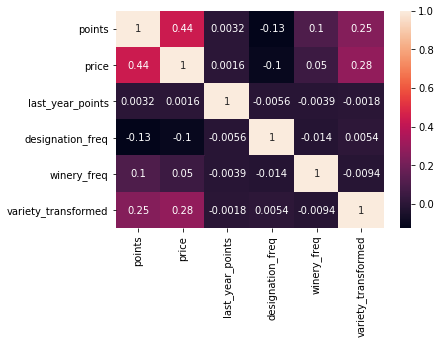

In [36]:
# Assuming we want to predict the price for a bottle of wine using the input features let's see how they are correlated with each other
# we will use the seaborn visualization library
import seaborn as sns

# correlation of frequency and target encoded dataset
# we removed the country one hot encoded features for the sake of displayability
sns.heatmap(wine_encod_df.iloc[:,0:6].corr(), annot=True)

### Feature correlation after scaling

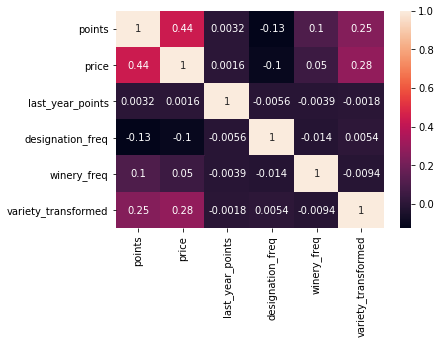

In [37]:
sns.heatmap(wine_scaled_df.iloc[:,0:6].corr(), annot=True)

### Feature correlation after normalization

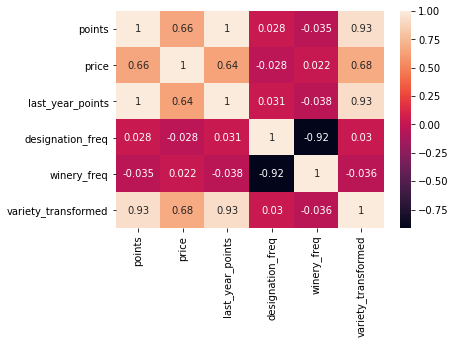

In [38]:
sns.heatmap(wine_normalized_df.iloc[:,0:6].corr(), annot=True)

### Feature correlation after binning

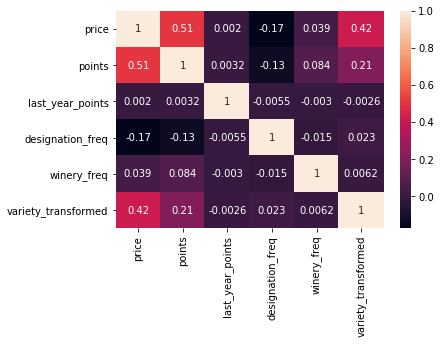

In [39]:
sns.heatmap(wine_binned_df.iloc[:,0:6].corr(), annot=True)

### Principal Component Analysis

In [50]:
# Lets check if PCA can help with our scaled dataset
# You can try this exercise for the rest of your datasets on your own
# we will first make the price feature as the first column as its our label
move_price = wine_scaled_df.pop('price')
wine_scaled_df.insert(0,'price',move_price)
wine_scaled_df.head()

,price,points,last_year_points,designation_freq,winery_freq,variety_transformed,country_1,country_2,country_3,country_4,...,country_39,country_40,country_41,country_42,country_43,country_44,country_45,country_46,country_47,country_48
0,0.100610,0.80,0.7,0.095421,0.058340,0.260535,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.046167,0.80,0.6,0.000000,0.145105,0.261886,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.037456,0.80,1.0,0.000000,0.088346,0.088498,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.026568,0.80,0.7,0.672782,0.803870,0.269223,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.027003,0.75,0.7,0.000000,0.088346,0.225253,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [51]:
# Let us use Scikit learn PCA to see the variability with 20 features
# only input features will be used, price will be ignore as its the target feature
import numpy as np
from sklearn.decomposition import PCA
pca_20 = PCA(n_components=20)
#ignore the first column as its target feature
pca_20.fit(wine_scaled_df.iloc[:,1:])

PCA(n_components=20)

In [52]:
print(pca_20.explained_variance_ratio_ *100)

[27.61619465 14.09297552  8.76254336  8.53355052  7.86265684  7.66539351
  4.08749879  3.39716159  3.25183729  3.02518259  2.35018136  2.08445308
  1.88961942  1.61447355  1.41769812  0.60665283  0.44511272  0.39916116
  0.16620317  0.1273224 ]


In [53]:
#88% of variance in the first 12 components, so thats what we will choose
#wine_reduced will become our input train dataset after PCA
pca_12 = PCA(n_components=12)
wine_reduced = pca_12.fit_transform(wine_scaled_df.iloc[:,1:])
wine_reduced.shape

(144030, 12)

# End of notebook
Please go back to Chapter 03 in the book Cloud-Native AI/ML on AWS to continue